## Early Warning System for Corporate Distress

ECE 143 - Group 14

Team Members: Kendra Chen, Zhuosheng Song, Matthew Alegrado, Jinglin Cao

This notebook presents a comprehensive bankruptcy prediction analysis using datasets from U.S. and Taiwanese companies. Through exploratory data analysis and predictive modeling, we identify critical financial indicators of corporate distress and build a robust pipeline to detect firms at high bankruptcy risk, and uncover the most influential factors driving corporate failure.

## 1.1 Primary Task

**Main task**: Build a model pipeline to assess company distress using financial indicators.

Throughout the pipeline development process, we also perform extensive exploratory data analysis to address key research questions. This includes examining the temporal trends in bankruptcy occurrences over the years, the distribution of bankrupt companies across industries, differences in financial profiles between U.S. and Taiwanese firms, class imbalance in the dataset, and the behavior of critical financial ratios leading up to bankruptcy.

## 1.2 Evaluation Metrics

Given the dataset's extreme class imbalance (approximately 5% bankrupt vs. 95% non‑bankrupt firms), accuracy is a highly misleading metric. A naive model that labels all companies as non-bankrupt would attain >95% accuracy yet fail entirely at identifying financial distress.

We therefore evaluate models using:

- **F1 score** on the bankruptcy class as the primary metric (balances precision and recall)  
- **Recall** on the bankruptcy class as the key secondary metric, since missing an actual bankruptcy (false negative) is considerably more costly than flagging a healthy firm


## 1.3 Baseline Approach

We define a baseline models to provide reference performance:

- Naive baseline: Predicts all companies as non-bankrupt. While this achieves high overall accuracy, it fails to detect any bankrupt firms, resulting in an F1 score of zero.

### 1.4 Validity Assessment

Model validity is established by confirming that performance on a held‑out test set reflects true generalization. No test data was accessed prior to final evaluation. The following controls were applied:

- 70%/15%/15% Train valid test separation with no overlap or leakage.

- Imbalance handling: SMOTE and selective oversampling to address the low bankruptcy rate

- Generalization checks: Confusion matrix inspection and feature importance review to ensure predictions align with financial intuition

These measures ensure that reported performance is reliable and driven by meaningful financial signals rather than artifacts or leakage.

## Imports and setup

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from utils.config import setup_environment
from utils.loader import load_data, basic_info, transfer_z_col_to_name
from utils.cleaner import unify_target_column, clean_data, zscore_transform, remove_outlier
from utils.plot import plot_hist, plot_corr_matrix, plot_trend, plot_bankrupt_features, plot_pca, plot_bin_rate, plot_corr_with_target

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    classification_report,
    confusion_matrix,
    precision_recall_curve
)
from imblearn.over_sampling import SMOTE
import shap

setup_environment()

utils loaded | data path: C:\Users\matta\Documents\GitHub\Company-Bankruptcy-Prediction-Revised\data


C:\ProgramData\anaconda3\envs\Bankruptcy_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ------------------------------
# Config
# ------------------------------
RANDOM_STATE = 42
TEST_SIZE = 0.3
VIF_THRESHOLD = 5
MISSING_DROP_THRESHOLD = 0.40
WINSOR_LOWER = 0.01
WINSOR_UPPER = 0.99
ABNORMAL_THRESH = 3
CORRELATION_THRESH = 0.15
MAX_ZERO_FRACTION = 0.2

OUTPUT_DIR = "artifacts"
MODEL_DIR = "models"
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

## Data Collection & Preprossing

### Data Collection

**Taiwanese Companies Financial Distress Dataset**

Source: Taiwanese Bankruptcy Prediction [Dataset]. (2020). UCI Machine Learning Repository. https://doi.org/10.24432/C5004D.

The data were collected from the Taiwan Economic Journal for the years 1999 to 2009. Company bankruptcy was defined based on the business regulations of the Taiwan Stock Exchange.

**American Companies Bankruptcy Prediction Dataset**

Source: https://www.kaggle.com/datasets/utkarshx27/american-companies-bankruptcy-prediction-dataset

The American bankruptcy dataset covers 8,262 publicly listed U.S. companies (NYSE & NASDAQ) from 1999 to 2018, providing annual financial ratios and bankruptcy outcomes.

### Data Preprocessing

To enable meaningful financial interpretation and cross-dataset comparison, we replaced the original anonymized feature names (e.g., X1, X2, …, X64) in the American Companies Bankruptcy Prediction dataset with their actual financial meanings (e.g., Net Income, Total Assets, Cost of Goods Sold, Debt Ratio, Return on Assets, etc.). The complete mapping table is provided in the dataset’s official documentation on the Kaggle page.

In [3]:
df_american_bankrupt = load_data("american_bankruptcy.csv")
df_taiwanese_bankrupt = load_data("taiwanese_bankruptcy.csv")

Loaded: (78682, 21) from C:\Users\matta\Documents\GitHub\Company-Bankruptcy-Prediction-Revised\data\american_bankruptcy.csv
Loaded: (6819, 96) from C:\Users\matta\Documents\GitHub\Company-Bankruptcy-Prediction-Revised\data\taiwanese_bankruptcy.csv


In [4]:
basic_info(df_american_bankrupt)

Missing value counts:
company_name                 0
status_label                 0
year                         0
Current Assets               0
Cost of Goods Sold           0
                            ..
Total Current Liabilities    0
Retained Earnings            0
Total Revenue                0
Total Liabilities            0
Total Operating Expenses     0
Length: 21, dtype: int64

Dataset info:
       company_name status_label   year Current Assets Cost of Goods Sold  \
count         78682        78682  78682          78682              78682   
unique         8971            2     20          65895              65690   
top          C_4081        alive   1999          0.002                  0   
freq             20        73462   5308             31                306   

       Depreciation and Amortization  EBITDA Inventory Net Income  \
count                          78682   78682     78682      78682   
unique                         36010   59060     38898      55550   
top 

In [5]:
basic_info(df_taiwanese_bankrupt)

Missing value counts:
Bankrupt?                                                   0
 ROA(C) before interest and depreciation before interest    0
 ROA(A) before interest and % after tax                     0
 ROA(B) before interest and depreciation after tax          0
 Operating Gross Margin                                     0
                                                           ..
 Liability to Equity                                        0
 Degree of Financial Leverage (DFL)                         0
 Interest Coverage Ratio (Interest expense to EBIT)         0
 Net Income Flag                                            0
 Equity to Liability                                        0
Length: 96, dtype: int64

Dataset info:
       Bankrupt?  ROA(C) before interest and depreciation before interest  \
count       6819                                               6819         
unique         2                                               3333         
top            0         

In [6]:
# cleaning
df_american_bankrupt = unify_target_column(df_american_bankrupt, column="status_label", mapping={"alive" : 0, "failed": 1}, rename="bankrupt")
df_american_bankrupt = clean_data(df_american_bankrupt)
df_taiwanese_bankrupt = clean_data(df_taiwanese_bankrupt)

In [7]:
df_american_bankrupt.head()

,bankrupt,year,current_assets,cost_of_goods_sold,depreciation_and_amortization,ebitda,inventory,net_income,total_receivables,market_value,net_sales,total_assets,total_long_term_debt,ebit,gross_profit,total_current_liabilities,retained_earnings,total_revenue,total_liabilities,total_operating_expenses
0,0,1999,511.2670,833.1070,18.3730,89.0310,336.0180,35.1630,128.3480,372.7519,1024.3330,740.9980,180.4470,70.6580,191.2260,163.8160,201.0260,1024.3330,401.4830,935.3020
1,0,2000,485.8560,713.8110,18.5770,64.3670,320.5900,18.5310,115.1870,377.1180,874.2550,701.8540,179.9870,45.7900,160.4440,125.3920,204.0650,874.2550,361.6420,809.8880
2,0,2001,436.6560,526.4770,22.4960,27.2070,286.5880,-58.9390,77.5280,364.5928,638.7210,710.1990,217.6990,4.7110,112.2440,150.4640,139.6030,638.7210,399.9640,611.5140
3,0,2002,396.4120,496.7470,27.1720,30.7450,259.9540,-12.4100,66.3220,143.3295,606.3370,686.6210,164.6580,3.5730,109.5900,203.5750,124.1060,606.3370,391.6330,575.5920
4,0,2003,432.2040,523.3020,26.6800,47.4910,247.2450,3.5040,104.6610,308.9071,651.9580,709.2920,248.6660,20.8110,128.6560,131.2610,131.8840,651.9580,407.6080,604.4670


In [8]:
df_taiwanese_bankrupt.head()

,bankrupt,roa_c_before_interest_and_depreciation_before_interest,roa_a_before_interest_and_after_tax,roa_b_before_interest_and_depreciation_after_tax,operating_gross_margin,realized_sales_gross_margin,operating_profit_rate,pre_tax_net_interest_rate,after_tax_net_interest_rate,non_industry_income_and_expenditure_revenue,...,current_liability_to_current_assets,net_income_to_total_assets,total_assets_to_gnp_price,no_credit_interval,gross_profit_to_sales,net_income_to_stockholder_s_equity,liability_to_equity,degree_of_financial_leverage_dfl,interest_coverage_ratio_interest_expense_to_ebit,equity_to_liability
0,1,0.3706,0.4244,0.4089,0.6015,0.6015,0.9990,0.7969,0.8088,0.3027,...,0.0870,0.7168,0.0092,0.6229,0.6015,0.8313,0.2902,0.0266,0.5641,0.0165
1,1,0.4643,0.5382,0.5167,0.6102,0.6102,0.9989,0.7974,0.8093,0.3036,...,0.0478,0.7953,0.0083,0.6237,0.6102,0.8400,0.2838,0.0307,0.5699,0.0208
2,1,0.4261,0.4990,0.4723,0.6015,0.6014,0.9989,0.7964,0.8084,0.3027,...,0.0253,0.7747,0.0400,0.6238,0.6014,0.8368,0.2902,0.0266,0.5637,0.0165
3,1,0.3998,0.4513,0.4577,0.5884,0.5884,0.9987,0.7970,0.8090,0.3033,...,0.0672,0.7396,0.0033,0.6229,0.5884,0.8347,0.2817,0.0267,0.5647,0.0240
4,1,0.4650,0.5384,0.5223,0.5988,0.5988,0.9990,0.7974,0.8093,0.3035,...,0.0477,0.7950,0.0039,0.6235,0.5988,0.8400,0.2785,0.0260,0.5699,0.0355


## EDA

Here, we try to understand data distributions and identify patterns so that they can hopefully guide our modeling decisions.

By definition, a company is considered bankrupt if it is unable to meet its financial obligations, meaning it cannot pay its debts as they come due. The exact criteria for bankruptcy vary across countries depending on legal and regulatory frameworks. This raises an interesting question for our dataset: how many companies are classified as bankrupt, and are there differences in the number of bankrupt companies between Taiwan and the United States?

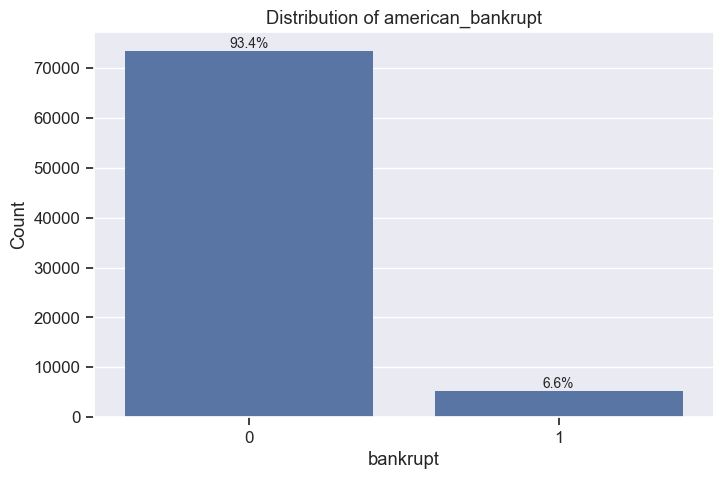

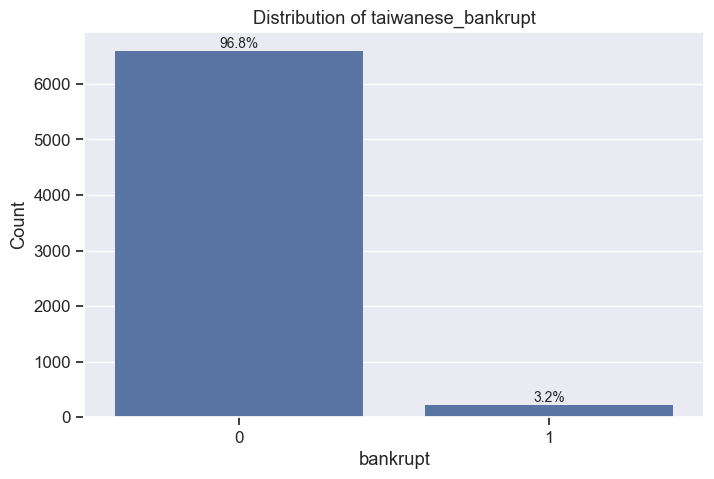

In [9]:
plot_hist(df=df_american_bankrupt,
          col="bankrupt", 
          df_name="american", 
          show_pct=True)

plot_hist(df=df_taiwanese_bankrupt,
          col="bankrupt", 
          df_name="taiwanese", 
          show_pct=True)

We are also interested in how the number of bankrupt companies varies across different years. Are there certain years with notably more bankruptcies, which might reflect periods of economic stress or financial crises? Since Taiwanese dataset doesn't have the time attribute, we'll analyze on American company only.

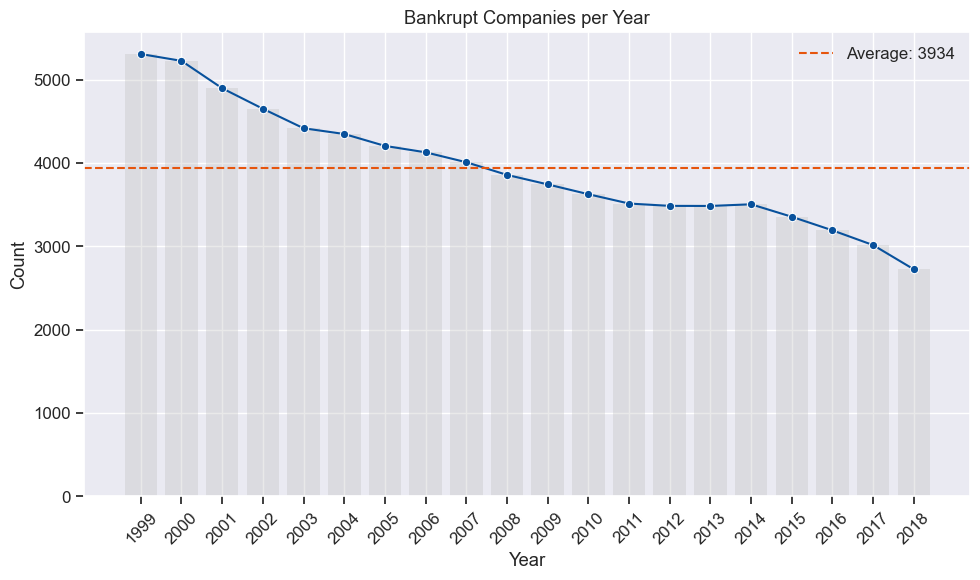

In [10]:
plot_trend(df_american_bankrupt, year_col="year", count_col="bankrupt",
           df_name="american", title="Bankrupt Companies per Year", show_bar=True, show_avg=True)


We were interested in whether bankrupt companies exhibit any particularly distinctive features. To investigate this, we calculated the absolute mean differences for all numerical variables and selected the top-K (here 3) features with the largest differences. The visualizations show that, for these features, the distributions of bankrupt and alive companies are very similar, with most of the data concentrated in a relatively narrow range. For example, the market value of both groups is mostly between 0 and 2000, with a long-tail extending to higher values. Interestingly, the extreme values in the long tail are predominantly from alive companies, representing notable outliers.

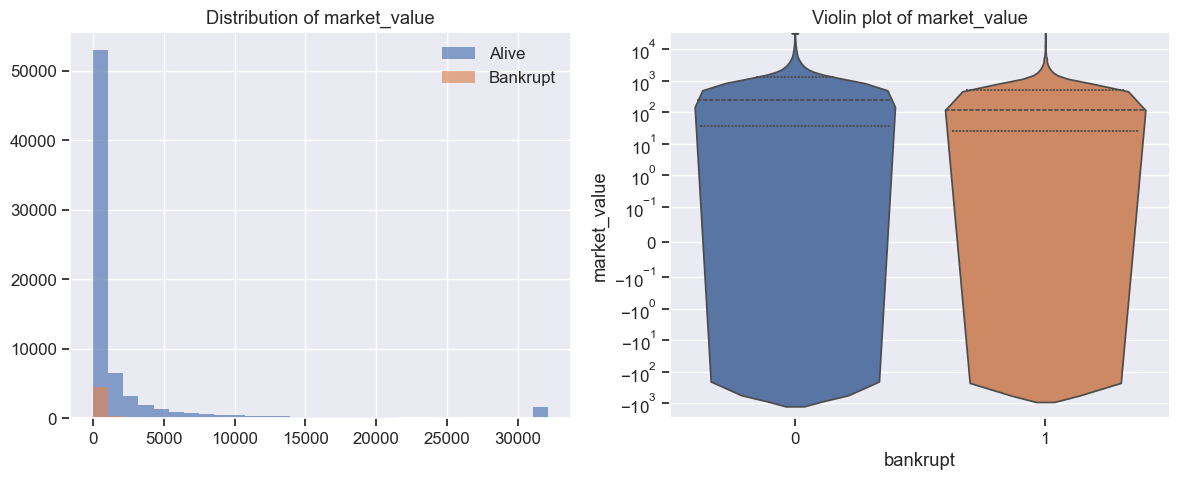

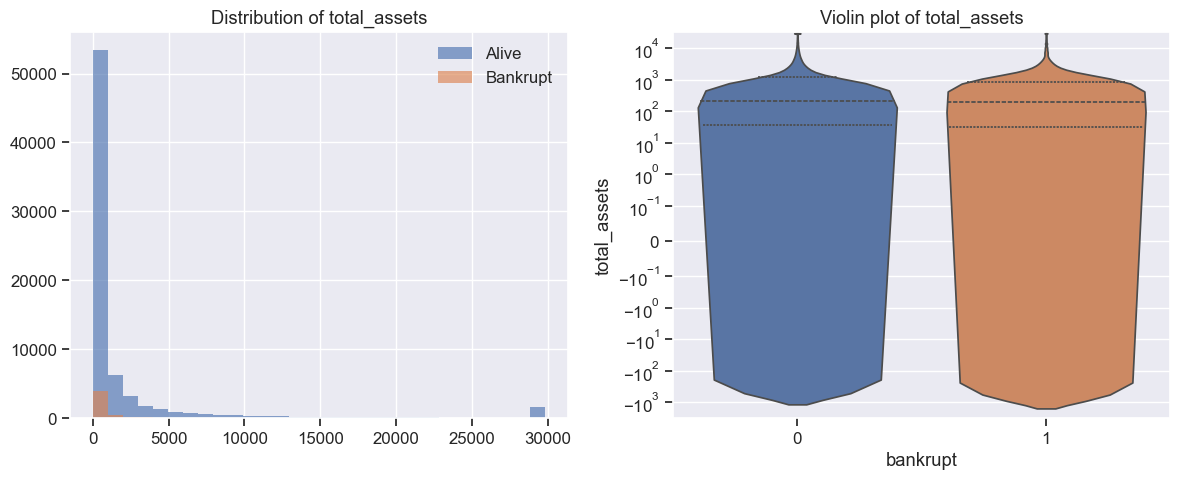

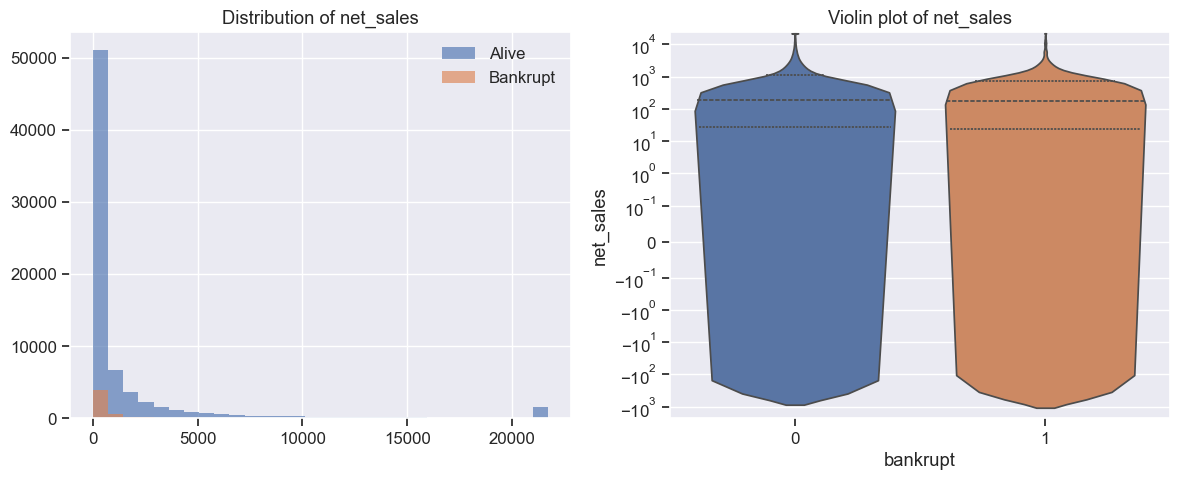

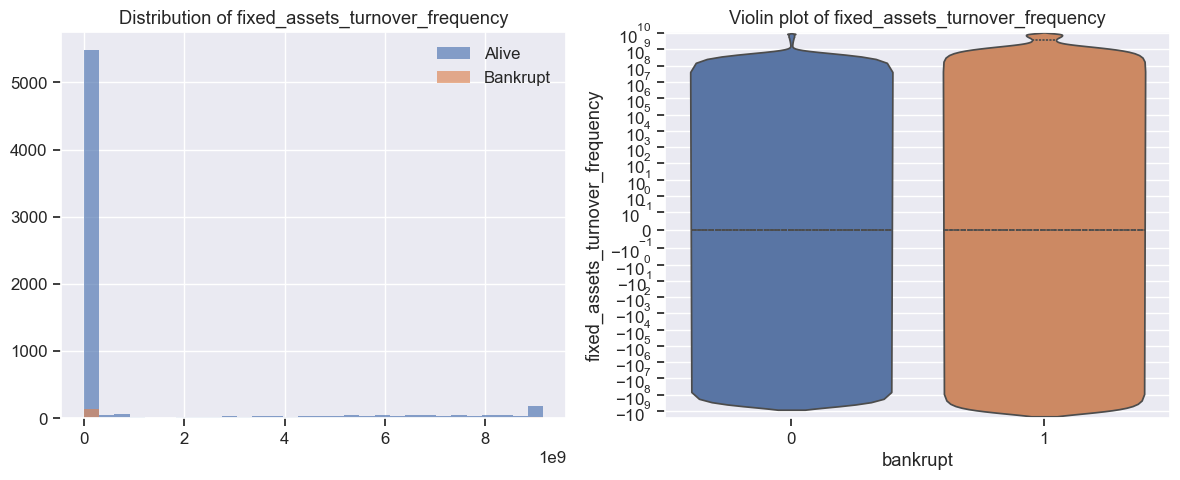

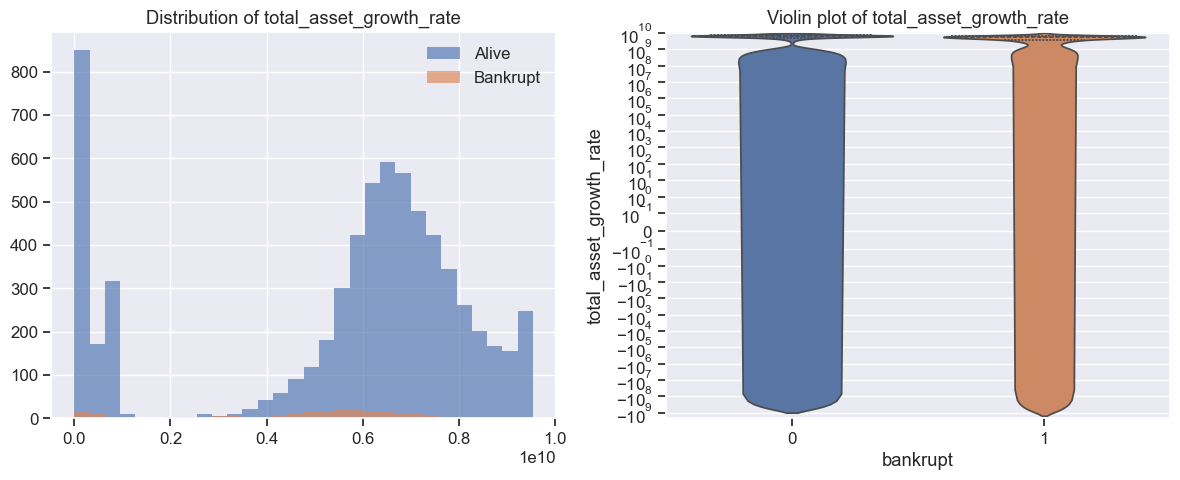

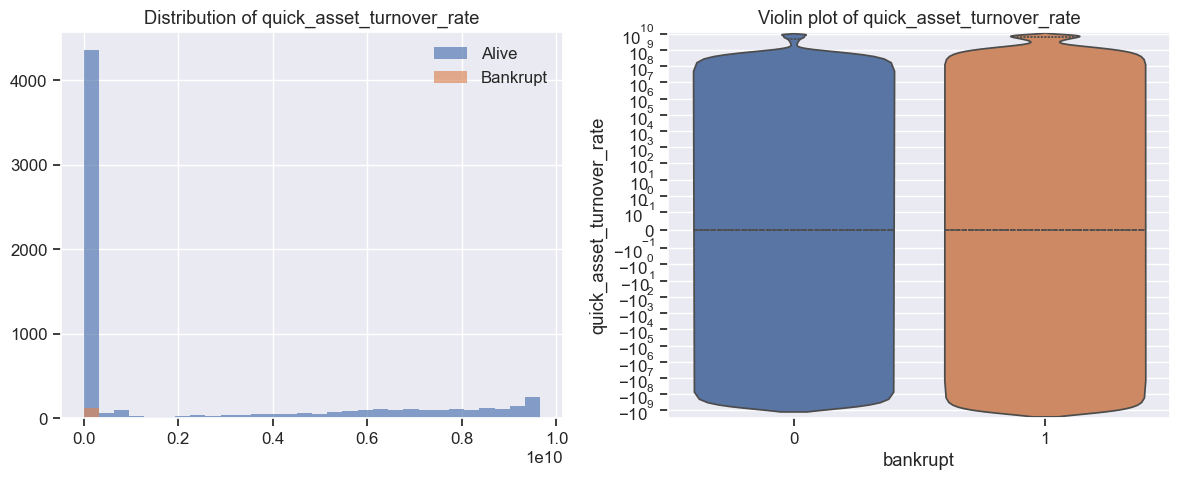

In [11]:
# plot top 3 
plot_bankrupt_features(
    df_american_bankrupt,
    target_col="bankrupt",
    df_name="american"
)

plot_bankrupt_features(
    df_taiwanese_bankrupt,
    target_col="bankrupt",
    df_name="taiwanese"
)

We have already observed some interesting patterns in the two datasets. Next, we will merge them to create a more comprehensive dataset for further analysis. Notably, the American dataset contains raw financial figures (e.g., current assets, cost of goods sold), whereas the Taiwanese dataset primarily uses computed ratios (e.g., ROA, EPS), and there are many duplicated or similar features (e.g., ROA (a), ROA (b)). Therefore, careful preprocessing is required before merging. To illustrate the structure and validate the need for further processing, we generated a correlation heatmap and a PCA plot.

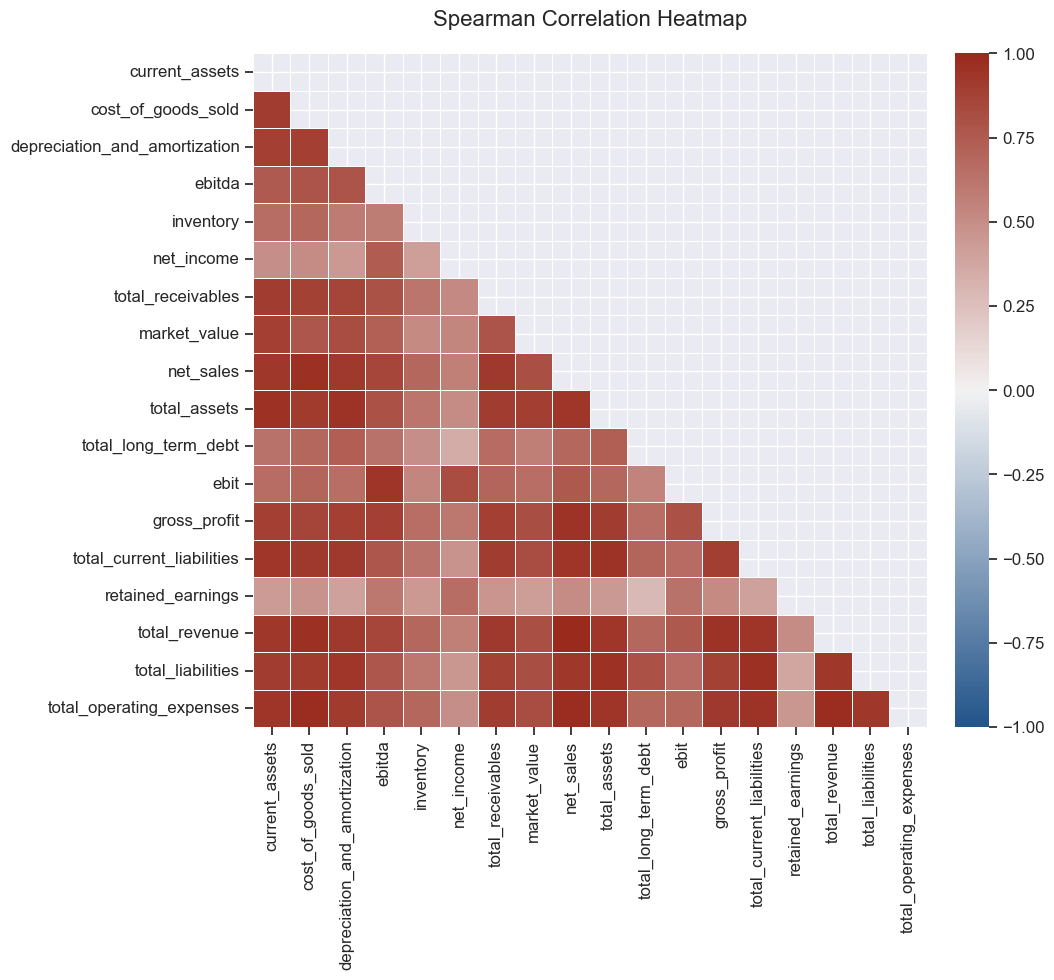

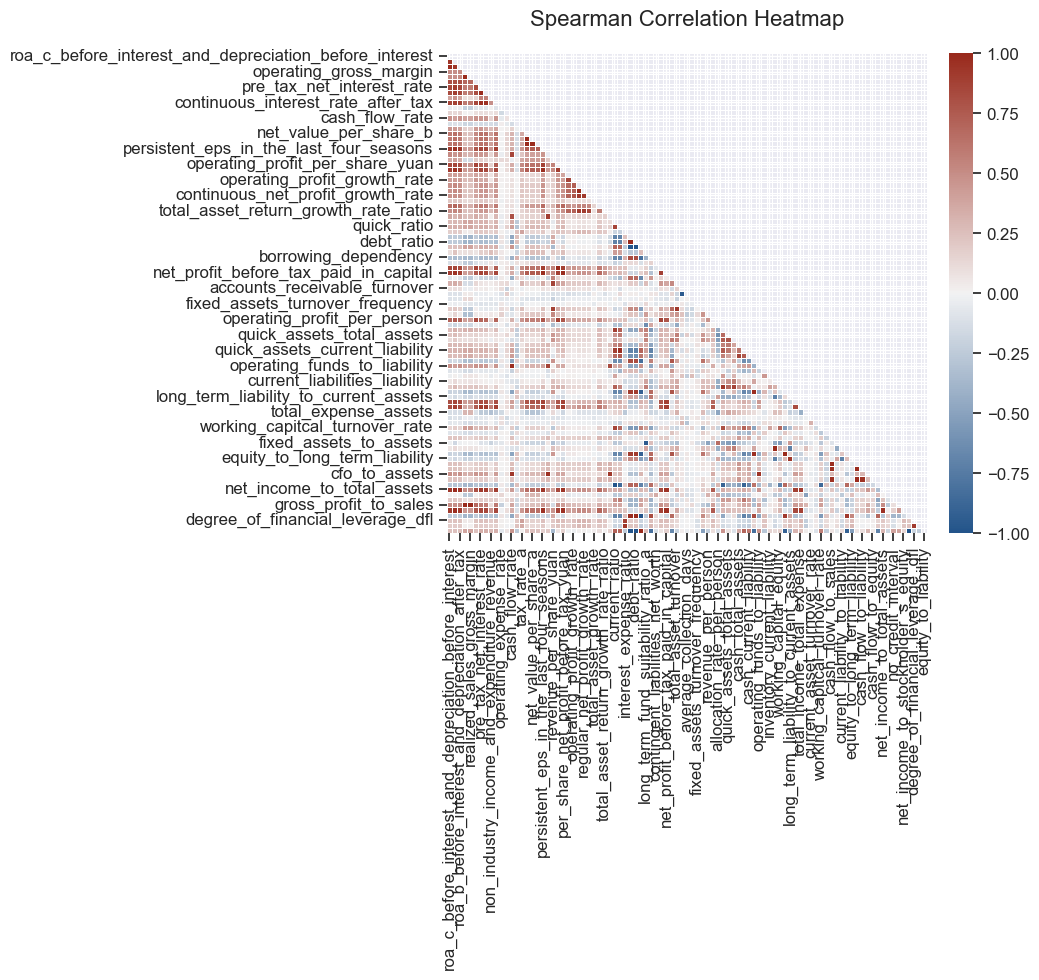

In [12]:
# American bankrupt plot are using raw data
plot_corr_matrix(
    df_american_bankrupt.drop(columns=['bankrupt', 'year']),
    method='spearman',
    df_name='american',
)

# Taiwanese bankrupt plot are using ratios calculated from raw data
plot_corr_matrix(
    df_taiwanese_bankrupt.drop(columns=['bankrupt']),
    method='spearman',
    df_name='taiwanese',

)

The Spearman correlation heatmap visually confirms the presence of extensive multicollinearity within the dataset, as evidenced by large, contiguous blocks of ratios displaying strong positive (dark red) and negative (dark blue) correlations. This high degree of inter-correlation demonstrates significant redundancy among the financial features.

We shall next see the PCA plot.

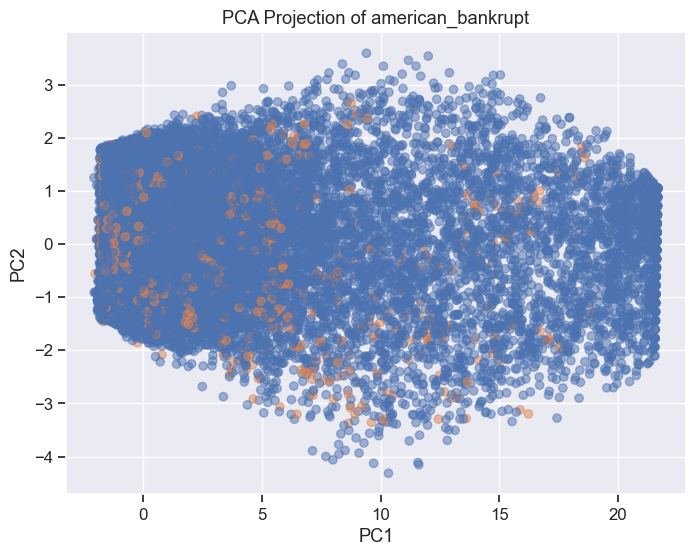

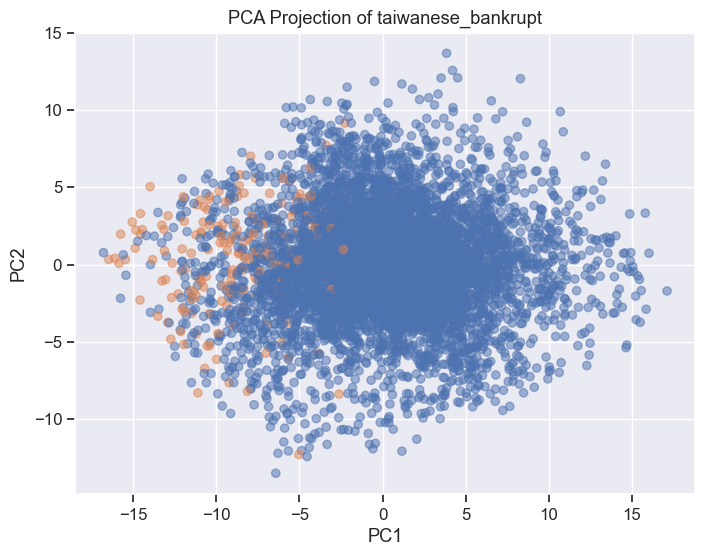

In [13]:
plot_pca(df=df_american_bankrupt, 
         target_col="bankrupt", 
         df_name="american")

plot_pca(df=df_taiwanese_bankrupt, 
         target_col="bankrupt", 
         df_name="taiwanese")

The PCA scatter plot shows a dense cluster of companies, indicating that the financial ratios cannot effectively separate bankrupt from non-bankrupt firms.

## Z-score model

In light of the above, we will further clean and preprocess the data. To simplify the analysis pipeline, we will use the well-known Z-score model introduced by Altman (1968) to predict bankruptcy. This model combines five key financial ratios capturing different aspects of a company's financial health: liquidity (working capital/total assets), profitability (retained earnings and EBIT/total assets), leverage (market value of equity/total debt), and operational efficiency (sales/total assets). These ratios were chosen because they summarize a firm's ability to generate profits, manage debts, and utilize assets effectively, providing a simple yet powerful indicator of bankruptcy risk.

In [14]:
df_american_z = zscore_transform(df_american_bankrupt, 
                 computed=False,
                 verbose=True,
                 manual_col_map={"total_debt" : "total_liabilities", "current_liabilities" : "total_current_liabilities"})
df_american_z = transfer_z_col_to_name(df_american_z)

df_american_z.head()

--- Raw Data Components Matching Results ---
Required keyword 'total_debt' matched to column: total_liabilities
Required keyword 'current_liabilities' matched to column: total_current_liabilities
Required keyword 'total_assets' matched to column: total_assets
Required keyword 'ebit' matched to column: ebit
Required keyword 'retained_earnings' matched to column: retained_earnings
Required keyword 'current_assets' matched to column: current_assets
Required keyword 'market_value_equity' matched to column: market_value
Required keyword 'sales' matched to column: net_sales


,working_capital_to_total_assets,retained_earnings_to_total_assets,ebit_to_total_assets,market_value_equity_to_total_debt,sales_to_total_assets,bankrupt
0,0.4689,0.2713,0.0954,0.9284,1.3824,0
1,0.5136,0.2908,0.0652,1.0428,1.2456,0
2,0.4030,0.1966,0.0066,0.9116,0.8994,0
3,0.2808,0.1807,0.0052,0.3660,0.8831,0
4,0.4243,0.1859,0.0293,0.7579,0.9192,0


In [15]:
df_temp = zscore_transform(df_taiwanese_bankrupt, 
                 computed=True,
                 verbose=True,
                 manual_col_map={"ebit_to_total_assets" : "net_income_to_total_assets", "market_value_equity_to_total_debt" : "equity_to_liability", "sales_to_total_assets" : "cash_flow_to_total_assets"})

df_temp['X5'] = df_temp['X5'] / df_taiwanese_bankrupt['cash_flow_to_sales']
df_taiwanese_z = transfer_z_col_to_name(df_temp)

df_taiwanese_z.head()

--- Computed Ratios Matching Results (using descriptions) ---
X1 (working_capital_to_total_assets) matched to column: working_capital_to_total_assets
X2 (retained_earnings_to_total_assets) matched to column: retained_earnings_to_total_assets
X3 (ebit_to_total_assets) matched to column: net_income_to_total_assets
X4 (market_value_equity_to_total_debt) matched to column: equity_to_liability
X5 (sales_to_total_assets) matched to column: cash_flow_to_total_assets


,working_capital_to_total_assets,retained_earnings_to_total_assets,ebit_to_total_assets,market_value_equity_to_total_debt,sales_to_total_assets,bankrupt
0,0.7022,0.9032,0.7168,0.0165,0.9494,1
1,0.7511,0.9311,0.7953,0.0208,0.9546,1
2,0.8295,0.9099,0.7747,0.0165,0.9571,1
3,0.7258,0.9069,0.7396,0.0240,0.8623,1
4,0.7518,0.9139,0.7950,0.0355,0.9268,1


In [16]:
df_merge = pd.concat([df_taiwanese_z, df_american_z], ignore_index=True)
# it's possible that when debt is small, the ratio becomes high
df_temp = remove_outlier(df_merge.drop(columns=['market_value_equity_to_total_debt']))
df_temp['market_value_equity_to_total_debt'] = df_merge['market_value_equity_to_total_debt']

df_merge = df_temp

working_capital_to_total_assets: clipping 264 values below -10.0, 0 values above 10.0
retained_earnings_to_total_assets: clipping 4613 values below -10.0, 1 values above 10.0
ebit_to_total_assets: clipping 104 values below -10.0, 0 values above 10.0
sales_to_total_assets: clipping 0 values below -10.0, 100 values above 10.0


In [17]:
basic_info(df_merge)

Missing value counts:
working_capital_to_total_assets      0
retained_earnings_to_total_assets    0
ebit_to_total_assets                 0
sales_to_total_assets                0
bankrupt                             0
market_value_equity_to_total_debt    0
dtype: int64

Dataset info:
       working_capital_to_total_assets  retained_earnings_to_total_assets  \
count                       85501.0000                         85501.0000   
mean                            0.1661                            -0.9971   
std                             0.9017                             2.7389   
min                           -10.0000                           -10.0000   
25%                             0.0535                            -0.8226   
50%                             0.2373                             0.0367   
75%                             0.4939                             0.3492   
max                             0.9904                            10.0000   

       ebit_to_total_a

That's a lot of work! Now, we have both z-score transformed columns of American company bankrupt dataset and Taiwanese company bankrupt dataset. We can do a lot more exploring!

The first natural question comes to the mind is does bankrupt companies have different z-scores than alive companies? 

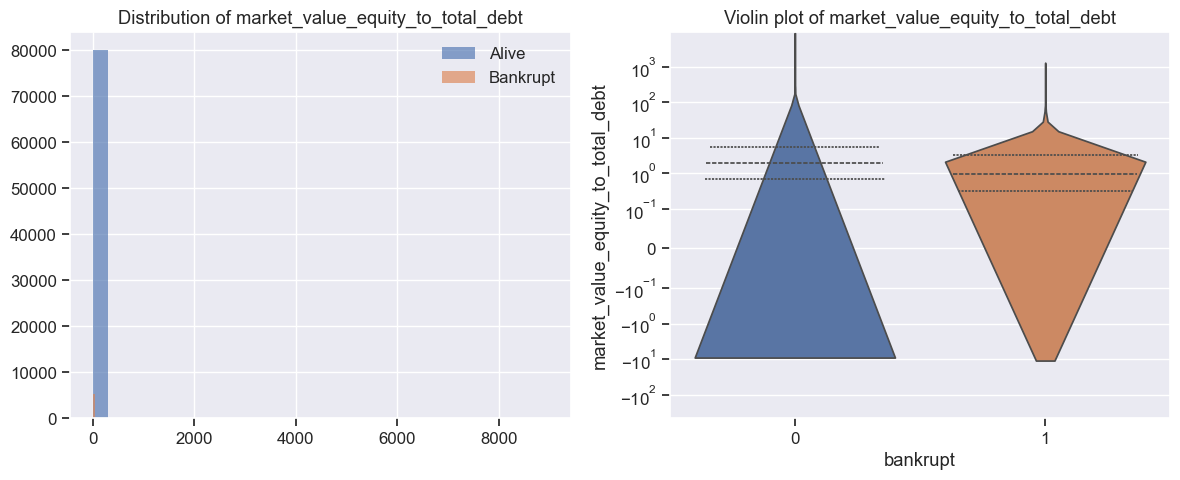

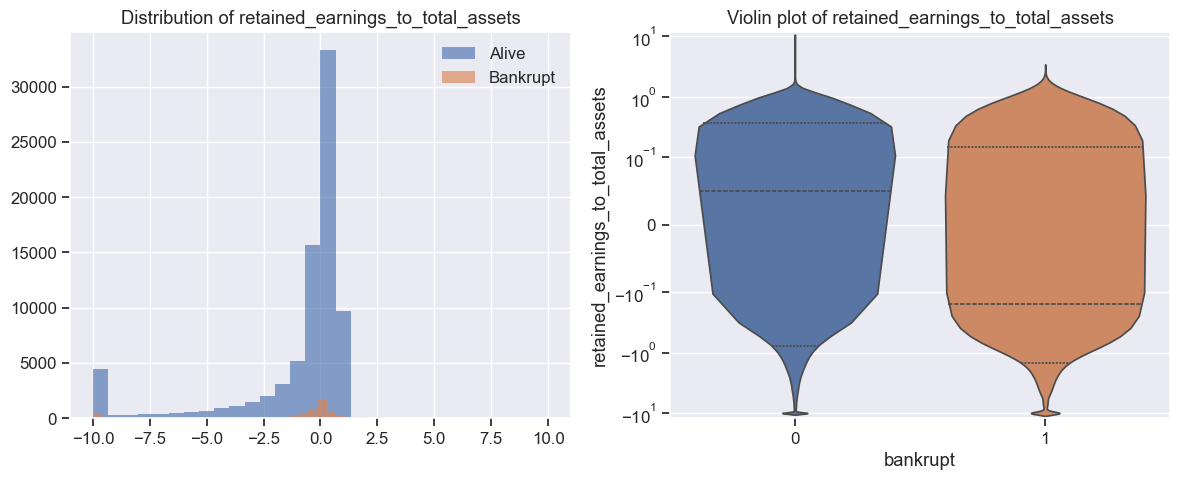

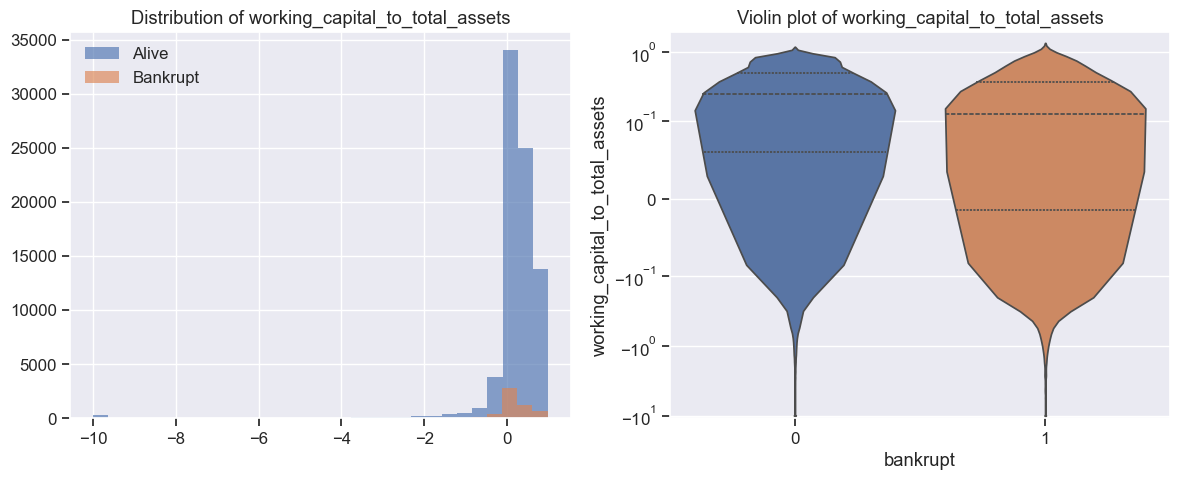

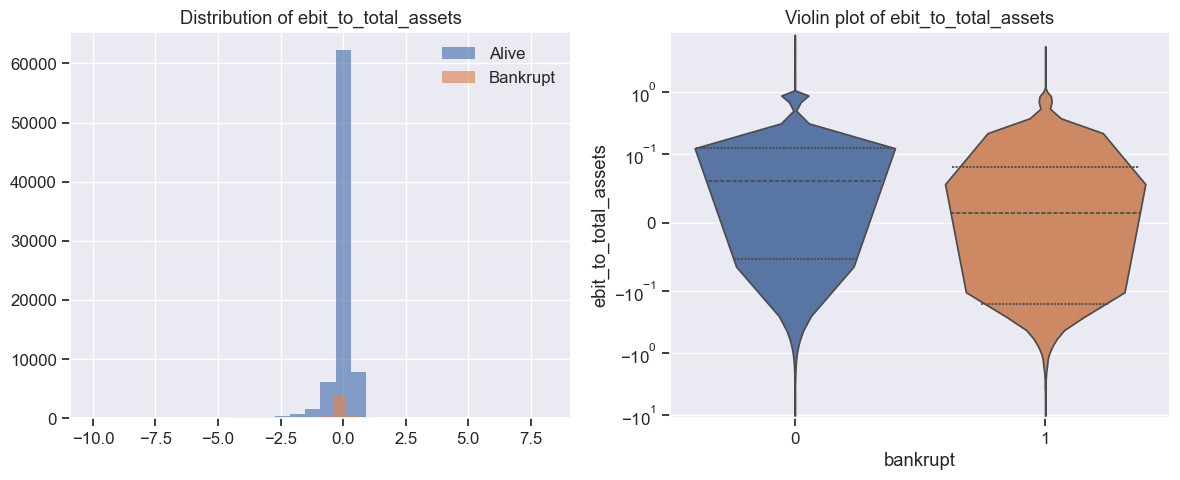

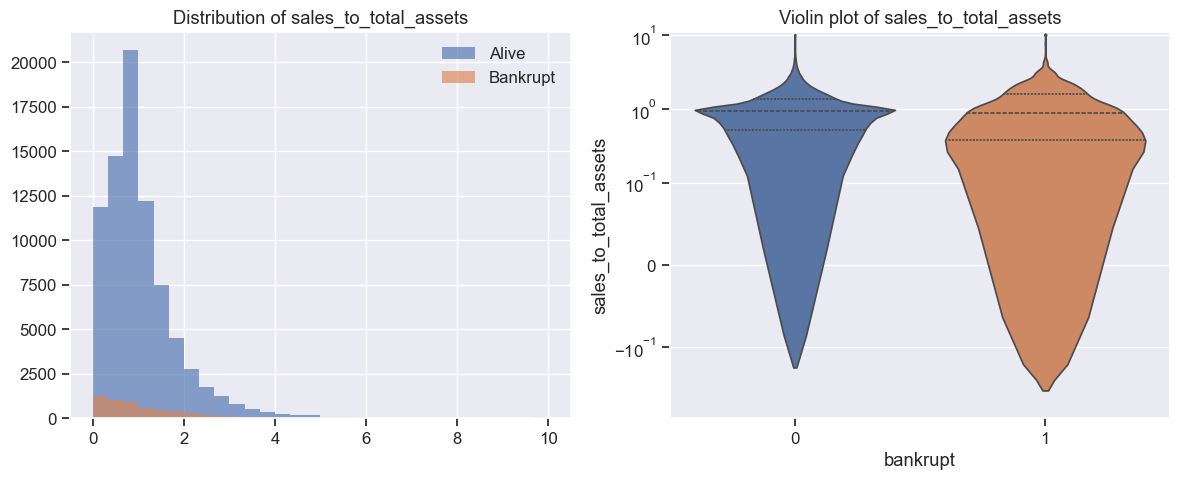

In [18]:
plot_bankrupt_features(
    df_merge,
    target_col="bankrupt",
    df_name="z",
    top_k=5
)

Things become more interesting, we can see that the shape of the violin plot begin to show some notable difference, meaning that z-score feature does have some predictive power on the dataset

Then, what about the impact of leverage level and profitability level? Do these impact bankruptcy as we would expect? 

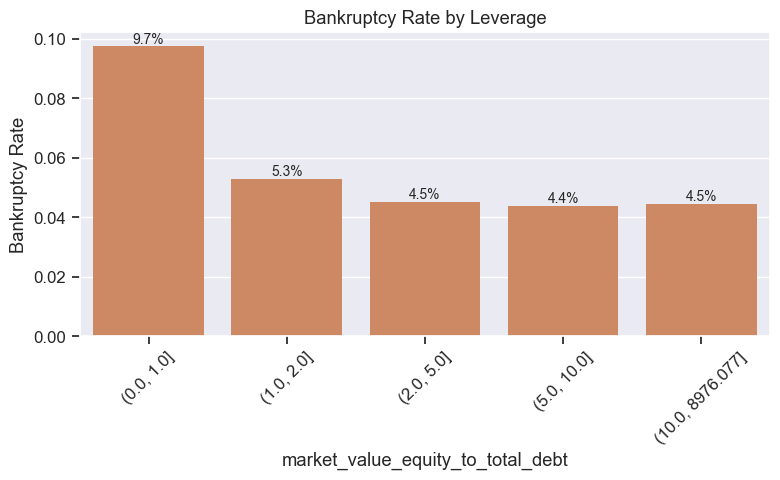

In [19]:
leverage_bins = [0, 1, 2, 5, 10, df_merge['market_value_equity_to_total_debt'].max()]
plot_bin_rate(df_merge, col='market_value_equity_to_total_debt', bins=leverage_bins,
              title="Bankruptcy Rate by Leverage")

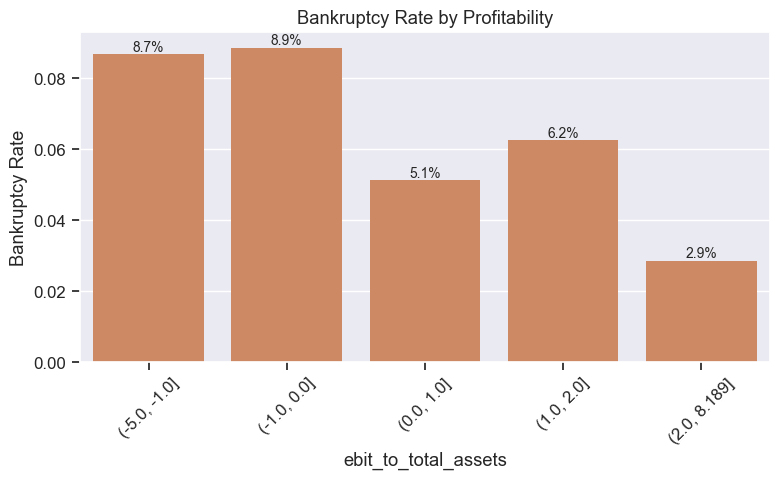

In [20]:
profit_bins = [-5, -1, 0, 1, 2, df_merge['ebit_to_total_assets'].max()]
plot_bin_rate(df_merge, col='ebit_to_total_assets', bins=profit_bins,
              title="Bankruptcy Rate by Profitability")


Finally, we want to see what are the factors that predict bankrupcty most. 

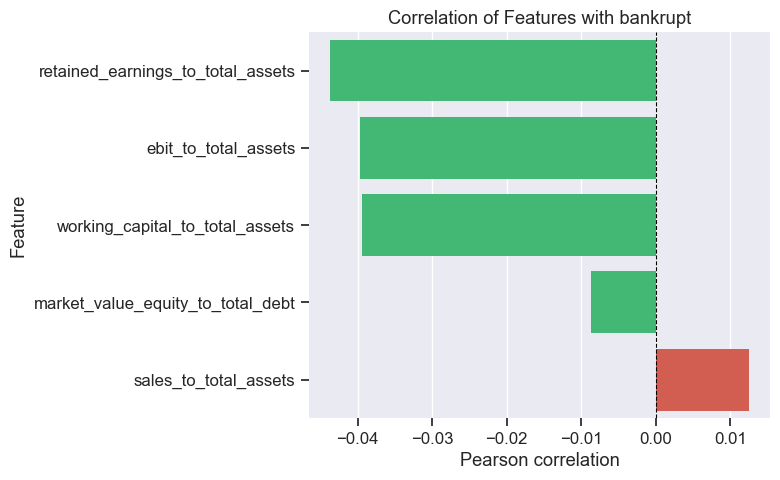

In [21]:
plot_corr_with_target(df_merge, target_col="bankrupt", df_name="zscore")

Conclusion: This cell shows the financial ratios that are most strongly correlated with bankruptcy. Positive ones (red bars) are risk factors, indicating higher likelihood of bankruptcy. The strongest risk signal is borrowing dependency, while the most protective risk factor is net income to stockholder equity.

## Modeling and Evaluation

First, we prepare the train/test data for the baseline model

In [22]:
# Train/Test split
y = df_merge["bankrupt"]
X = df_merge.drop(columns=["bankrupt"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

**Baseline 1: Naive baseline**

In [23]:
# Naive baseline uses the default prediction of not bankrupt
y_pred = [0] * len(y_test)

print("\nClassification Report (F1-optimized threshold):")
print(classification_report(y_test, y_pred, digits=3))


Classification Report (F1-optimized threshold):
              precision    recall  f1-score   support

           0      0.936     1.000     0.967     24019
           1      0.000     0.000     0.000      1632

    accuracy                          0.936     25651
   macro avg      0.468     0.500     0.484     25651
weighted avg      0.877     0.936     0.906     25651



C:\ProgramData\anaconda3\envs\Bankruptcy_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\ProgramData\anaconda3\envs\Bankruptcy_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\ProgramData\anaconda3\envs\Bankruptcy_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

Conclusion: The naive baseline assumes every company is not bankrupt. As seen above, this leads to a very high accuracy (96.8%), but the result is misleading. Notice that the recall and F1 score are zero, reflecting the fact that the model is unable to accurately identify any bankruptcy cases.

**Baseline 2: Insight based forecasting**

In [24]:
df = df_merge

# Pick common ratios
DOMAIN_FEATURES = [
    "current_ratio",
    "quick_ratio",
    "working_capital_to_total_assets",
    "retained_earnings_to_total_assets",
    "ebit_to_total_assets",
    "market_value_of_equity_to_total_liabilities",
    "sales_to_total_assets",
    "cash_flow_to_liability",
    "cash_flow_to_assets",
    "net_income_to_total_assets",
    "liability_to_equity",
]

# Only keep features that exist in the df
selected_features = [c for c in DOMAIN_FEATURES if c in df.columns]

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    df[selected_features], y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

Random Forest Metrics
ROC-AUC: 0.6981740073626354
PR-AUC: 0.14201177298198664
{'0': {'precision': 0.93715089254326, 'recall': 0.9988758899204796, 'f1-score': 0.9670294236195083, 'support': 24019.0}, '1': {'precision': 0.46, 'recall': 0.014093137254901961, 'f1-score': 0.027348394768133173, 'support': 1632.0}, 'accuracy': 0.9362208101048692, 'macro avg': {'precision': 0.69857544627163, 'recall': 0.5064845135876908, 'f1-score': 0.49718890919382075, 'support': 25651.0}, 'weighted avg': {'precision': 0.9067930017541835, 'recall': 0.9362208101048692, 'f1-score': 0.9072438620786154, 'support': 25651.0}}


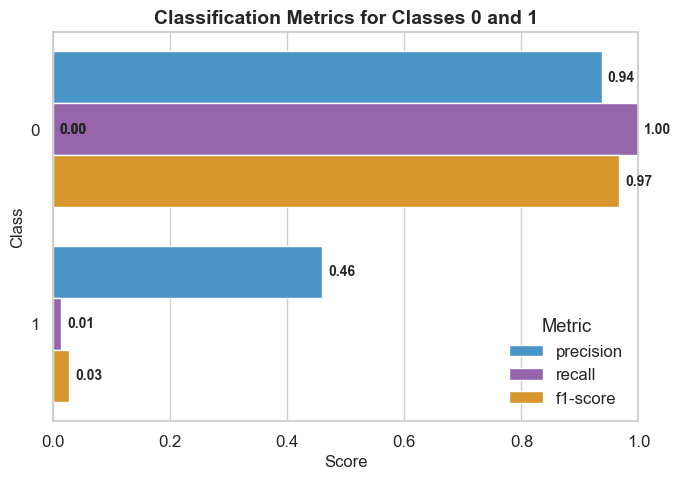

C:\Users\matta\AppData\Local\Temp\ipykernel_43680\4014337326.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rf_importances.values, y=rf_importances.index, palette="viridis")


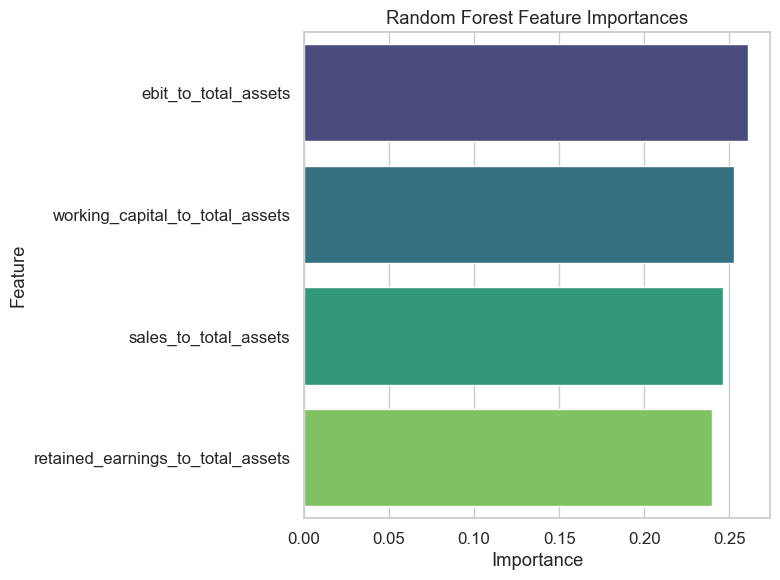

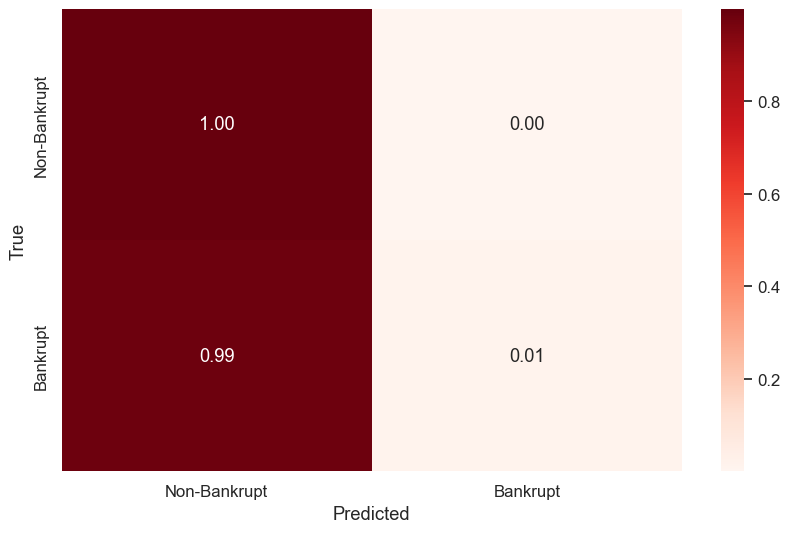

In [25]:
# Random Forest model
rf = RandomForestClassifier(
    n_estimators=800,
    random_state=RANDOM_STATE,
    class_weight="balanced",
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print("Random Forest Metrics")
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))
print("PR-AUC:", average_precision_score(y_test, y_proba_rf))
print(report_dict := classification_report(y_test, y_pred_rf, digits=3, output_dict=True))

# Convert to DataFrame and keep only class labels
report_df = pd.DataFrame(report_dict).T
report_df = report_df[report_df.index.str.isdigit()]

# Melt for plotting
plot_df = report_df.reset_index().melt(id_vars='index',
                                       value_vars=['precision', 'recall', 'f1-score'],
                                       var_name='Metric', value_name='Score')

# Plot
plt.figure(figsize=(7,5))
sns.set_style("whitegrid")
palette = {'precision':'#3498db', 'recall':'#9b59b6', 'f1-score':'#f39c12'}

ax = sns.barplot(data=plot_df, x='Score', y='index', hue='Metric', palette=palette)

# Annotate bars properly
for bar in ax.patches:
    width = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2
    ax.text(width + 0.01, y, f'{width:.2f}', va='center', fontsize=10, fontweight='bold')

# Labels & style
plt.xlabel("Score", fontsize=12)
plt.ylabel("Class", fontsize=12)
plt.title("Classification Metrics for Classes 0 and 1", fontsize=14, fontweight='bold')
plt.xlim(0,1)
plt.legend(title="Metric", loc='lower right')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "baseline_classification_metrics.png"), dpi=200)
plt.show()
plt.close()

# Feature importances
rf_importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x=rf_importances.values, y=rf_importances.index, palette="viridis")
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "random_forest_importance.png"), dpi=200)
plt.show()
plt.close()

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)
cm_rates = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

labels = ["Non-Bankrupt", "Bankrupt"]
plt.figure(figsize=(10,6))
sns.heatmap(cm_rates, annot=True, fmt=".2f", cmap="Reds",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig(os.path.join(OUTPUT_DIR, "insight_baseline_confusion_matrix.png"), dpi=200)
plt.show()
plt.close()


Conclusion: The Random Forest model has high accuracy (96.8%) and good ROC-AUC (0.91). However, it is still a weak predictor of bankruptcy, much like the naive case. Recall is 0.09 and the F1 score is 0.15. Most bankrupt companies are not identified by the model. The Random Forest model improves upon the naive baseline, but it still needs to be better at identifying bankrupt companies.

**Improved Model**

Feature Engineering

We chose to select features that have highest absolute correlation with bankrupt, plus manually selected features if they were not already in the feature columns.

In [26]:
corr = df.corr()['bankrupt'].drop('bankrupt')

risk = corr[corr >= CORRELATION_THRESH].sort_values(ascending=False)
safe = corr[corr <= -CORRELATION_THRESH].sort_values()
top_corr = pd.concat([risk, safe]).sort_values()

# Features from correlation
corr_features = set(top_corr.index)

# Add domain ones if they exist
manual_additions = [f for f in DOMAIN_FEATURES if f in df.columns and f not in corr_features]

candidate_features = sorted(corr_features.union(manual_additions))

print("Corr-selected features:", len(corr_features))
print("Manual domain features:", manual_additions)
print("Total candidate features:", len(candidate_features))

Corr-selected features: 0
Manual domain features: ['working_capital_to_total_assets', 'retained_earnings_to_total_assets', 'ebit_to_total_assets', 'sales_to_total_assets']
Total candidate features: 4


By applying VIF pruning, we remove features that convey overlapping information, ensuring that the remaining predictors are not redundant and reducing multicollinearity before model training.

In [27]:
# VIF-based iterative pruning
from utils.vif import reduce_vif_ratio

X_reduced, vif_drops = reduce_vif_ratio(df[candidate_features], ratio=VIF_THRESHOLD)

print("\nFinal feature set after VIF reduction:")
for c in X_reduced.columns:
    print("  -", c)


Final feature set after VIF reduction:
  - ebit_to_total_assets
  - retained_earnings_to_total_assets
  - sales_to_total_assets
  - working_capital_to_total_assets


In [28]:
y = df["bankrupt"]

# Train/Valid/Test Split
X_train, X_temp, y_train, y_temp = train_test_split(
    X_reduced, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=RANDOM_STATE,
    stratify=y_temp
)

print("\nTrain/Valid/Test shapes:")
print("X_train:", X_train.shape, "   X_val:", X_val.shape, "   X_test:", X_test.shape)


Train/Valid/Test shapes:
X_train: (59850, 4)    X_val: (12825, 4)    X_test: (12826, 4)


Augment negative samples to mitigate skewness

In [29]:
# Negative Sample Augmentation (Hard Negatives)

from utils.feature_engineering import augment_negative_samples

X_train_aug, y_train_aug = augment_negative_samples(
    X_train, y_train,
    factor=1.0,        # create 100% more hard negatives
    noise_scale=0.1,  # noise intensity
    random_state=RANDOM_STATE
)

print("After negative augmentation:", np.bincount(y_train_aug))

After negative augmentation: [112084   3808]


SMOTE oversampling

In [30]:
# SMOTE Oversampling for Class (bankrupt=1)

smote = SMOTE(random_state=RANDOM_STATE)
X_train_bal, y_train_bal = smote.fit_resample(X_train_aug, y_train_aug)

print("After SMOTE balancing:", np.bincount(y_train_bal))

After SMOTE balancing: [112084 112084]



=== Improved Model Metrics ===
ROC-AUC: 0.7008990159344337
PR-AUC: 0.13560021596183688
{'0': {'precision': 0.9509254066180595, 'recall': 0.8470441298917568, 'f1-score': 0.8959837942575304, 'support': 12010.0}, '1': {'precision': 0.13674812030075187, 'recall': 0.35661764705882354, 'f1-score': 0.19769021739130435, 'support': 816.0}, 'accuracy': 0.815842819273351, 'macro avg': {'precision': 0.5438367634594057, 'recall': 0.6018308884752902, 'f1-score': 0.5468370058244174, 'support': 12826.0}, 'weighted avg': {'precision': 0.8991268204933969, 'recall': 0.815842819273351, 'f1-score': 0.8515578189945614, 'support': 12826.0}}


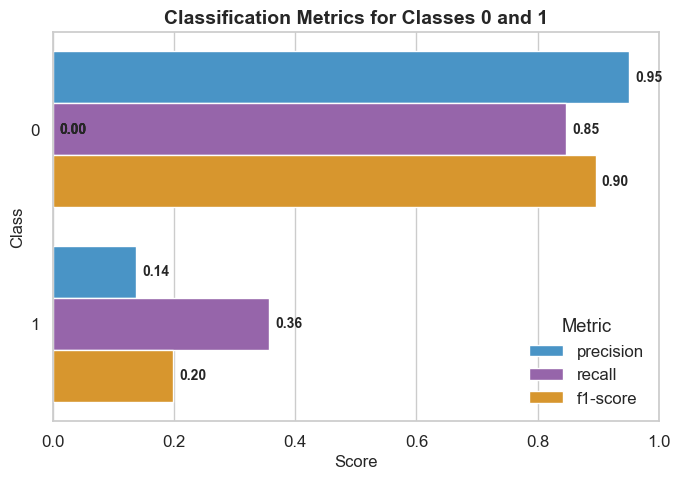

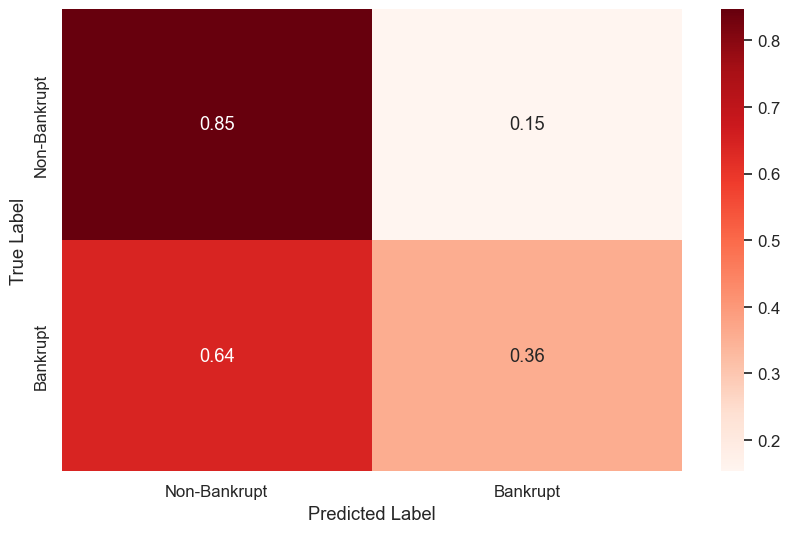

In [41]:
# Random Forest With SHAP
model = RandomForestClassifier(
    n_estimators=800,
    max_depth=6,
    random_state=RANDOM_STATE,
    class_weight="balanced",
    n_jobs=-1
)
model.fit(X_train, y_train)

# Maximize F1 validation set, for class 1
from utils.tune_threshold import tune_threshold

best_thr = tune_threshold(model, X_val, y_val)

# Test result on test set
y_proba_test =  model.predict_proba(X_test)[:, 1]
y_pred_best = (y_proba_test >= best_thr).astype(int)

print("\n=== Improved Model Metrics ===")
print("ROC-AUC:", roc_auc_score(y_test, y_proba_test))
print("PR-AUC:", average_precision_score(y_test, y_proba_test))
print(report_dict := classification_report(y_test, y_pred_best, digits=3, output_dict=True))

# Convert to DataFrame and keep only class labels
report_df = pd.DataFrame(report_dict).T
report_df = report_df[report_df.index.str.isdigit()]

# Melt for plotting
plot_df = report_df.reset_index().melt(id_vars='index',
                                       value_vars=['precision', 'recall', 'f1-score'],
                                       var_name='Metric', value_name='Score')

# Plot
plt.figure(figsize=(7,5))
sns.set_style("whitegrid")
palette = {'precision':'#3498db', 'recall':'#9b59b6', 'f1-score':'#f39c12'}

ax = sns.barplot(data=plot_df, x='Score', y='index', hue='Metric', palette=palette)

# Annotate bars properly
for bar in ax.patches:
    width = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2
    ax.text(width + 0.01, y, f'{width:.2f}', va='center', fontsize=10, fontweight='bold')

# Labels & style
plt.xlabel("Score", fontsize=12)
plt.ylabel("Class", fontsize=12)
plt.title("Classification Metrics for Classes 0 and 1", fontsize=14, fontweight='bold')
plt.xlim(0,1)
plt.legend(title="Metric", loc='lower right')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "improved_classification_metrics.png"), dpi=200)
plt.show()
plt.close()

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_best)
cm_rates = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
labels = ['Non-Bankrupt', 'Bankrupt']

plt.figure(figsize=(10,6))
sns.heatmap(cm_rates, annot=True, fmt=".2f", cmap="Reds", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig(os.path.join(OUTPUT_DIR, "improved_confusion_matrix.png"), dpi=200)
plt.show()
plt.close()


Conclusion: The improved model retains a high accuracy (95.6%), while showing improvements on recall and F1 score. Recall is 0.58, while F1 is 0.46. These metrics show that it improves at identifying companies in the bankrupt class, while still retaining a high accuracy. There is a slight trade off between overall accuracy and ability to correctly identify bankrupt companies. Precision shows a decrease (0.38), but the model overall has a better balance between identifying false positives and actual bankruptcies. The ROC-AUC and PR-AUC, 0.89 and 0.39 repsectively, show that it is better at identifying bankrupt companies (the smaller class) than the baseline before.

In [32]:
df.head()

,working_capital_to_total_assets,retained_earnings_to_total_assets,ebit_to_total_assets,sales_to_total_assets,bankrupt,market_value_equity_to_total_debt
0,0.7022,0.9032,0.7168,0.9494,1,0.0165
1,0.7511,0.9311,0.7953,0.9546,1,0.0208
2,0.8295,0.9099,0.7747,0.9571,1,0.0165
3,0.7258,0.9069,0.7396,0.8623,1,0.0240
4,0.7518,0.9139,0.7950,0.9268,1,0.0355


100%|===================| 119313/119700 [00:33<00:00]        

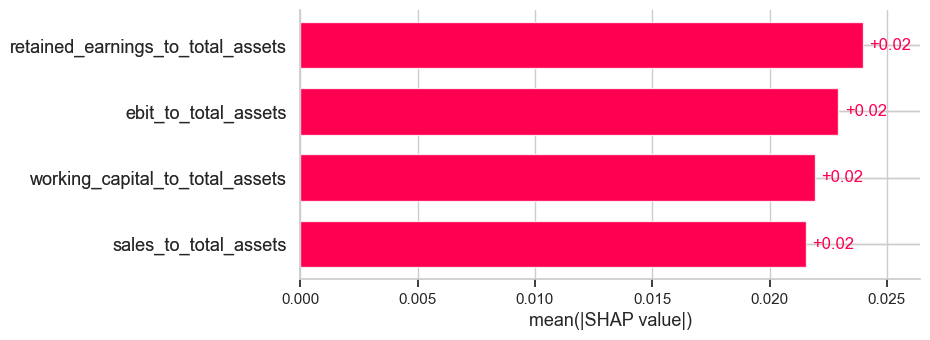

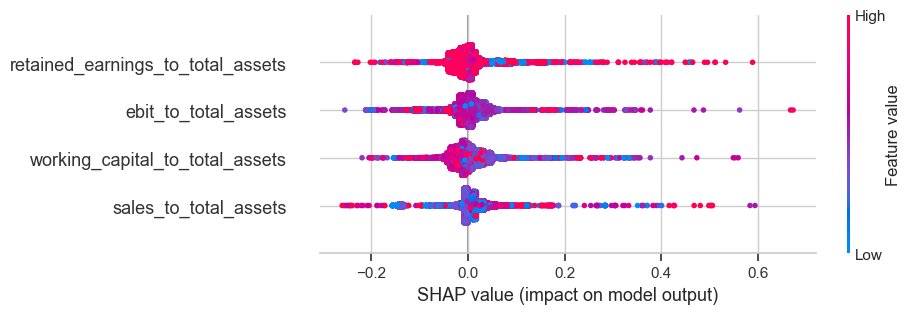

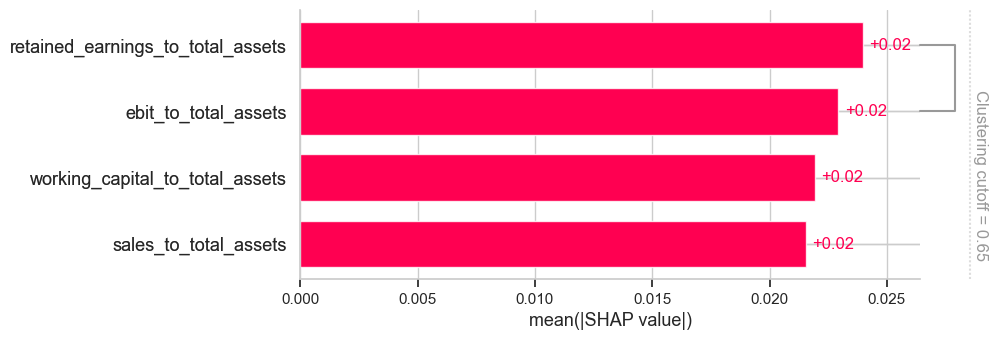

In [34]:
model_shap = RandomForestClassifier(
    n_estimators=1,
    max_depth=8,
    random_state=RANDOM_STATE
)
model_shap.fit(X_train, y_train)

# Fitting SHAP to Random Forest classifier
explainer = shap.TreeExplainer(model_shap, X_train)
shap_values = explainer.shap_values(X_train)

#Shap values for positive class
sv = shap_values[:,:,1]
# sv = df[y]
sv_plot = sv.reshape(sv.shape[0], sv.shape[1])
base = explainer.expected_value[1]

# Build shap explanation object
expl = shap.Explanation(values=sv_plot, base_values=base, data=X_train, feature_names=list(X_train.columns))

clustering = shap.utils.hclust(X_train, y_train)
# bar plot
plt.figure()
ax = shap.plots.bar(expl, max_display=10, show=False)  # 注意加 show=False
plt.savefig(os.path.join(OUTPUT_DIR, "shap_expl_bar.png"), dpi=200, bbox_inches='tight')
plt.show()
plt.close()

# beeswarm plot
plt.figure()
ax = shap.plots.beeswarm(expl, max_display=10, show=False)
plt.savefig(os.path.join(OUTPUT_DIR, "shap_expl_beeswarm.png"), dpi=200, bbox_inches='tight')
plt.show()
plt.close()

# clustering bar plot
plt.figure()
ax = shap.plots.bar(expl, clustering=clustering, clustering_cutoff=0.65, 
                    max_display=20, show=False)
plt.savefig(os.path.join(OUTPUT_DIR, "shap_clustering.png"), dpi=200, bbox_inches='tight')
plt.show()
plt.close()


Using SHAP analysis on the bankrupting class, we can determine the importance ranking of each feature in our current model from the bar plot, which plots each feature's absolute effect on classification. Using the beeswarm plot, we can also see what values are correlated with bankrupting vs. succeeding (further to right means the feature pushes classifier to predict bankruptcy).

Adding clustering to the analysis, we can also see how the features correlate with each other. This gives us a reduced feature set by grouping the impact of correlated features.

In [36]:
# SHAP values (positive class)
mean_abs_shap = np.abs(sv).mean(axis=0)
mean_abs_shap = pd.Series(mean_abs_shap, index=X_train.columns)

# Pick features above threshold
threshold = 0.05
selected_features = mean_abs_shap[mean_abs_shap >= threshold].index.tolist()
print("Selected SHAP features:", selected_features)

# Reduced dataset
X_reduced_shap = X[selected_features]
y = df["bankrupt"]

X_train_shap, X_temp_shap, y_train_shap, y_temp_shap = train_test_split(
    X_reduced_shap, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

X_val_shap, X_test_shap, y_val_shap, y_test_shap = train_test_split(
    X_temp_shap, y_temp_shap,
    test_size=0.5,
    random_state=RANDOM_STATE,
    stratify=y_temp_shap
)

# Random forest
model = RandomForestClassifier(
    n_estimators=800,
    max_depth=6,
    random_state=RANDOM_STATE,
    class_weight="balanced",
    n_jobs=-1
)
model.fit(X_train_shap, y_train_shap)

# Threshold tuning
from utils.tune_threshold import tune_threshold
best_thr = tune_threshold(model, X_val_shap, y_val_shap)

# Test set predictions
y_proba_test = model.predict_proba(X_test_shap)[:, 1]
y_pred_best = (y_proba_test >= best_thr).astype(int)
y_pred_test = model.predict(X_test_shap)

# Metrics
print("ROC-AUC:", roc_auc_score(y_test_shap, y_proba_test))
print("PR-AUC:", average_precision_score(y_test_shap, y_proba_test))
print(report_dict := classification_report(y_test_shap, y_pred_test, digits=3, output_dict=True))

# Convert to DataFrame and keep only class labels
report_df = pd.DataFrame(report_dict).T
report_df = report_df[report_df.index.str.isdigit()]

# Melt for plotting
plot_df = report_df.reset_index().melt(id_vars='index',
                                       value_vars=['precision', 'recall', 'f1-score'],
                                       var_name='Metric', value_name='Score')

# Plot
plt.figure(figsize=(7,5))
sns.set_style("whitegrid")
palette = {'precision':'#3498db', 'recall':'#9b59b6', 'f1-score':'#f39c12'}

ax = sns.barplot(data=plot_df, x='Score', y='index', hue='Metric', palette=palette)

# Annotate bars properly
for bar in ax.patches:
    width = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2
    ax.text(width + 0.01, y, f'{width:.2f}', va='center', fontsize=10, fontweight='bold')

# Labels & style
plt.xlabel("Score", fontsize=12)
plt.ylabel("Class", fontsize=12)
plt.title("Classification Metrics for Classes 0 and 1", fontsize=14, fontweight='bold')
plt.xlim(0,1)
plt.legend(title="Metric", loc='lower right')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "shap_classification_metrics.png"), dpi=200)
plt.show()
plt.close()

# Confusion matrix
cm = confusion_matrix(y_test_shap, y_pred_test)
cm_rates = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

labels = ["Non-Bankrupt", "Bankrupt"]
plt.figure(figsize=(10,6))
sns.heatmap(cm_rates, annot=True, fmt=".2f", cmap="Reds",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig(os.path.join(OUTPUT_DIR, "shap_confusion_matrix.png"), dpi=200)
plt.show()
plt.close()


Selected SHAP features: []


ValueError: at least one array or dtype is required

Training a new model on just the most relevant features post-clustering (>=0.05 mean Shapley value) has only a slight reduction in precision and F1 score, while increasing recall on only 6 of the 13 features from the original dataset after VIF pruning.

We can use these particular metrics further downstream using monitoring rules and thresholds on these 6 particular features instead of the larger 13 or full ~90-dimensional data. We could even have users imput these values and return bankrupt/non-bankrupt predictions and warnings if they are close to the threshold.

## Simple Threshold with Decision Tree

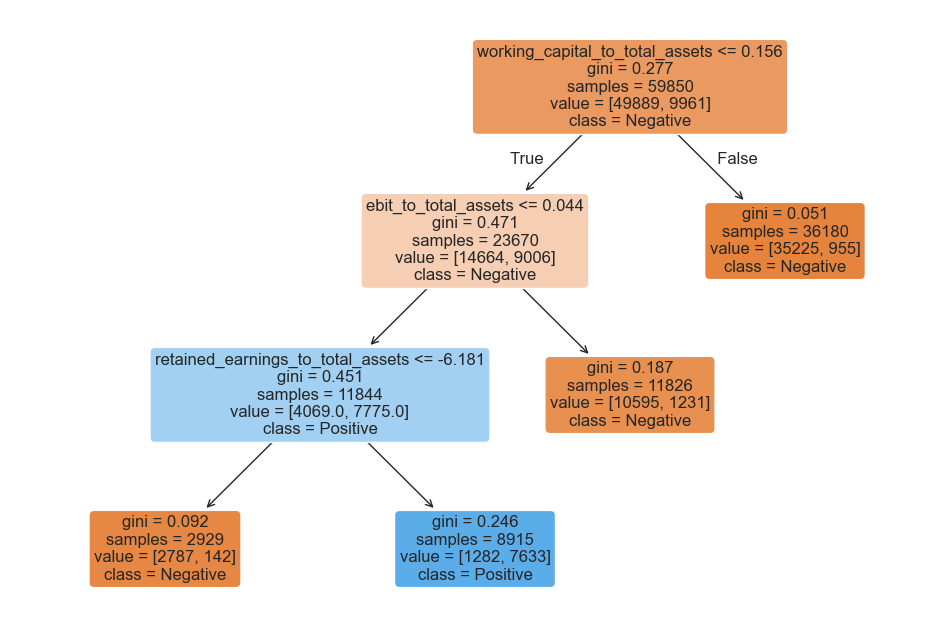

|--- working_capital_to_total_assets <= 0.16
|   |--- ebit_to_total_assets <= 0.04
|   |   |--- retained_earnings_to_total_assets <= -6.18
|   |   |   |--- class: False
|   |   |--- retained_earnings_to_total_assets >  -6.18
|   |   |   |--- class: True
|   |--- ebit_to_total_assets >  0.04
|   |   |--- class: False
|--- working_capital_to_total_assets >  0.16
|   |--- class: False



In [44]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Train a very shallow decision tree to mimic the Random Forest
proxy_tree = DecisionTreeClassifier(
    max_depth=3,               
    min_samples_leaf=30,
    min_impurity_decrease=0.01,  # prevent meaningless splits
    random_state=RANDOM_STATE
)
proxy_tree.fit(X_train, model.predict_proba(X_train)[:, 1] > best_thr)   

# Visualization
plt.figure(figsize=(12,8))
plot_tree(proxy_tree, feature_names=X_train.columns, 
          class_names=['Negative','Positive'], filled=True, rounded=True, fontsize=12)
plt.savefig(os.path.join(OUTPUT_DIR, "decision_tree.png"), dpi=200)
plt.show()
plt.close()

# Export rules
from sklearn.tree import export_text
rules = export_text(proxy_tree, feature_names=list(X_train.columns))
print(rules)

From the decision tree, we can see there're two flags for bankrupt companies

- Per Share Net Profit Before Tax Yuan <= 0.171

- Quick Ratio < 0.005

## Save the result

In [ ]:
from datetime import datetime

# Save the final model for pipeline use
import joblib
joblib.dump(model, os.path.join(MODEL_DIR, "final_model.pkl"))
print(f"Final model saved → {MODEL_DIR}/final_model.pkl")

# Save final feature columns
feature_columns = X_train_shap.columns.tolist()   
joblib.dump(feature_columns, os.path.join(MODEL_DIR, "feature_columns.pkl"))
print(f"Feature columns ({len(feature_columns)} features) saved → {MODEL_DIR}/feature_columns.pkl")

# Save final threshold
metadata = {
    "best_threshold": best_thr,          
    "model_date": datetime.now().strftime("%Y-%m-%d"),
    "per_share_net_profit_before_tax_yuan_thr": 0.171,
    "quick_ratio_thr": 0.005 
}
joblib.dump(metadata, os.path.join(MODEL_DIR, "model_metadata.pkl"))
print(f"Metadata & thresholds saved → {MODEL_DIR}/model_metadata.pkl")

# Save a tiny inference example so anyone can test instantly
example_df = X_train_shap.head(10).copy()
example_df["true_label"] = y_train.head(10).values
example_df.to_csv(f"{MODEL_DIR}/sample_input_for_testing.csv", index=False)
print(f"Sample input saved → {MODEL_DIR}/sample_input_for_testing.csv")